## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [2]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Se grafica la data "original" de Demanda en sector eléctrico

Text(0, 0.5, 'Demanda [MMpcd]')

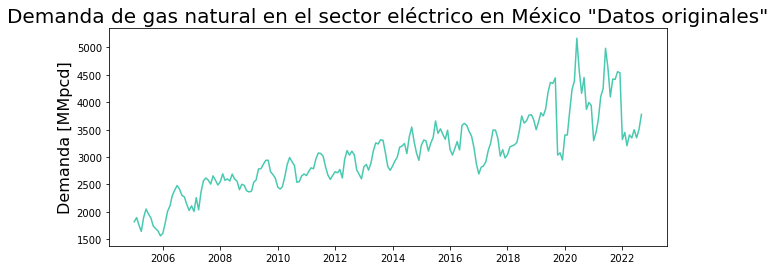

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

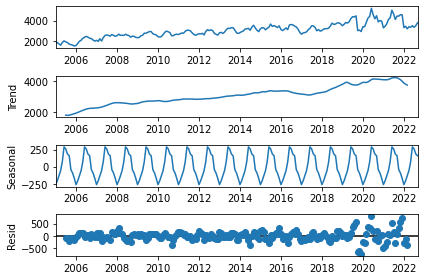

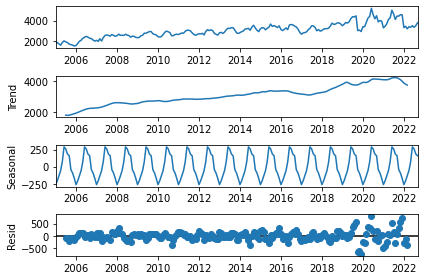

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se grafica la distribución de la data "original" de TRAIN de Demanda en sector eléctrico

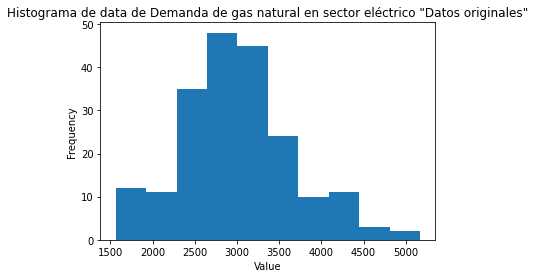

In [6]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

In [7]:
demanda_electrico_original_train_data.mean()

Demanded_Gas    2999.074876
dtype: float64

In [8]:
demanda_electrico_original_train_data.std()

Demanded_Gas    667.375493
dtype: float64

Se lleva a cabo una prueba de normalidad a los datos originales de TRAIN de Demanda en sector eléctrico

In [9]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_data.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.449201490304391
p-value: 0.024122729621181227


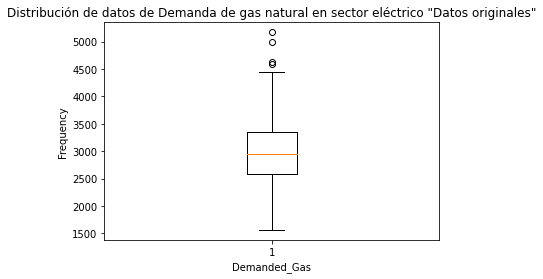

In [10]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
n_input = 24

data = demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data 

demanda_electrico_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [13]:
demanda_electrico_original_train_generator[0]

(array([[1819.58, 1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05,
         1889.66, 1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33,
         2006.88, 2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49,
         2273.91, 2134.41, 2025.98]]),
 array([2108.85]))

In [14]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_generator))


Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


### Se define y entrena la FFNN  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [15]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU.

La primer cada Dense constará de N, nodos y n_input inputs. Por lo que el número de parámetros a estimar para esta primer capa sería Parámetros_n_capa_densa = n_input * #Nodos + # Nodos Donde n_input * #Nodos: Representa la matriz de pesos Y # Nodos: el vector de bias

In [17]:
n_input = 24
n_features = 1

# define model
model_FF_electrico_sin_tratamiento = Sequential()
model_FF_electrico_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_electrico_sin_tratamiento.add(Dense(1))
model_FF_electrico_sin_tratamiento.compile(optimizer='Adam', loss='mse')

In [18]:
model_FF_electrico_sin_tratamiento.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 24, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator. Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoras" y el +1 valor después de los n_input como variable dependiente Y. y asi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)

In [19]:
model_FF_electrico_sin_tratamiento.fit(demanda_electrico_original_train_generator, epochs=15)


Epoch 1/15


177/177 [==============================] - 1s 2ms/step - loss: 2044488.0000
Epoch 2/15
177/177 [==============================] - 0s 2ms/step - loss: 184310.2656
Epoch 3/15
177/177 [==============================] - 0s 2ms/step - loss: 181495.9844
Epoch 4/15
177/177 [==============================] - 0s 2ms/step - loss: 189644.5938
Epoch 5/15
177/177 [==============================] - 0s 2ms/step - loss: 191228.8438
Epoch 6/15
177/177 [==============================] - 0s 2ms/step - loss: 182768.6406
Epoch 7/15
177/177 [==============================] - 1s 3ms/step - loss: 185008.4375
Epoch 8/15
177/177 [==============================] - 0s 2ms/step - loss: 186748.4219
Epoch 9/15
177/177 [==============================] - 0s 2ms/step - loss: 186156.2812
Epoch 10/15
177/177 [==============================] - 0s 2ms/step - loss: 184498.1250
Epoch 11/15
177/177 [==============================] - 0s 2ms/step - loss: 186818.7188
Epoch 12/15
177/177 [==============================] - 0s 2ms/

Se grafica la perdida por epoch

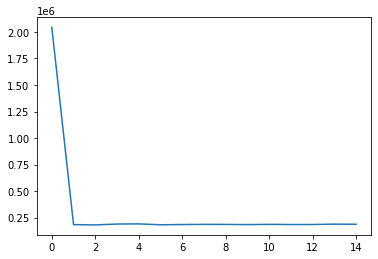

In [20]:
loss_per_epoch_model_FF = model_FF_electrico_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_FF_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [21]:
data = demanda_electrico_original_train_data['Demanded_Gas'].values

demanda_electrico_train_batch_sin_tratamiento = data[-n_input:]

demanda_electrico_train_batch_sin_tratamiento

array([3037.44, 3076.62, 2947.09, 3402.47, 3402.47, 3819.3 , 4235.25,
       4387.91, 5168.27, 4581.99, 4163.77, 4451.61, 3869.77, 3996.14,
       3941.12, 3298.43, 3454.21, 3681.3 , 4104.82, 4243.93, 4985.53,
       4631.85, 4098.81, 4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [22]:
demanda_electrico_train_batch_sin_tratamiento_reshaped = demanda_electrico_train_batch_sin_tratamiento.reshape(1,n_input, n_features)
demanda_electrico_train_batch_sin_tratamiento_reshaped

array([[[3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [23]:
model_FF_electrico_sin_tratamiento.predict(demanda_electrico_train_batch_sin_tratamiento_reshaped)

1/1 [==============================] - 0s 305ms/step


array([[[3267.8171],
        [3309.947 ],
        [3170.6638],
        [3660.3325],
        [3660.3325],
        [4108.548 ],
        [4555.8164],
        [4719.9717],
        [5559.0894],
        [4928.665 ],
        [4478.954 ],
        [4788.468 ],
        [4162.8184],
        [4298.7026],
        [4239.5405],
        [3548.4583],
        [3715.968 ],
        [3960.1565],
        [4415.5654],
        [4565.1504],
        [5362.589 ],
        [4982.2793],
        [4409.1035],
        [4759.198 ]]], dtype=float32)

Y se observa el valor predicho para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [24]:
model_FF_electrico_sin_tratamiento.predict(demanda_electrico_train_batch_sin_tratamiento_reshaped)[0][-1][0]

1/1 [==============================] - 0s 29ms/step


4759.198

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [25]:
demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [26]:
n_input = 24
n_features = 1

In [27]:
test_predictions_model_FF_electrico_sin_pretratamiento = []

first_eval_batch = demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape
    

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step


In [28]:
test_predictions_model_FF_electrico_sin_pretratamiento

[4759.198,
 5119.216,
 5506.341,
 5922.615,
 6370.2324,
 6851.5527,
 7369.1147,
 7925.6475,
 8524.085,
 9167.581,
 9859.53,
 10603.58]

In [29]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_FF_electrico_sin_pretratamiento_array = np.array(test_predictions_model_FF_electrico_sin_pretratamiento)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_FF_sin_pretratamiento_rescaled = test_predictions_model_FF_electrico_sin_pretratamiento_array.reshape(-1, 1)

test_predictions_model_FF_sin_pretratamiento_rescaled

array([[ 4759.198 ],
       [ 5119.216 ],
       [ 5506.341 ],
       [ 5922.615 ],
       [ 6370.2324],
       [ 6851.5527],
       [ 7369.1147],
       [ 7925.6475],
       [ 8524.085 ],
       [ 9167.581 ],
       [ 9859.53  ],
       [10603.58  ]], dtype=float32)

Se grafican los 12 meses de test vs el forecast del modelo FFNN sin la data pretratada

Text(0, 0.5, 'Demanda [MMpcd]')

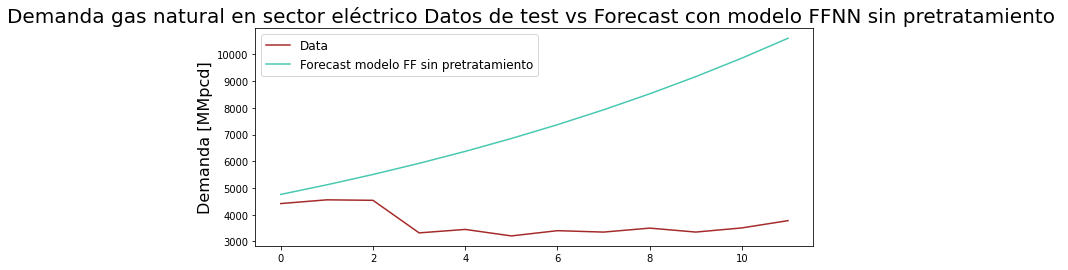

In [30]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_FF_sin_pretratamiento_rescaled, color='#48C9B0')
plt.legend(('Data', 'Forecast modelo FF sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo FFNN sin pretratamiento ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [31]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_FF_electrico_sin_pretratamiento = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_FF_sin_pretratamiento_rescaled)
RMSE_predictions_model_FF_electrico_sin_pretratamiento= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_FF_sin_pretratamiento_rescaled))

print('MAPE:', MAPE_predictions_model_FF_electrico_sin_pretratamiento)
print('RMSE:', RMSE_predictions_model_FF_electrico_sin_pretratamiento)

MAPE: 1.041812558413315
RMSE: 4209.5713419955855


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos Feed Forward Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [32]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [33]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [34]:
csv_demanda_electrico_original_para_tratamiento =csv_demanda_electrico_original.copy()
csv_demanda_electrico_original_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


In [35]:
demanda_electrico_pretratamiento_media = remove_replace_outliers_media(csv_demanda_electrico_original_para_tratamiento['Demanded_Gas'])
demanda_electrico_pretratamiento_media

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    1642.70
2005-05-01    1895.54
               ...   
2022-05-01    3350.03
2022-06-01    3498.70
2022-07-01    3350.97
2022-08-01    3506.42
2022-09-01    3778.37
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

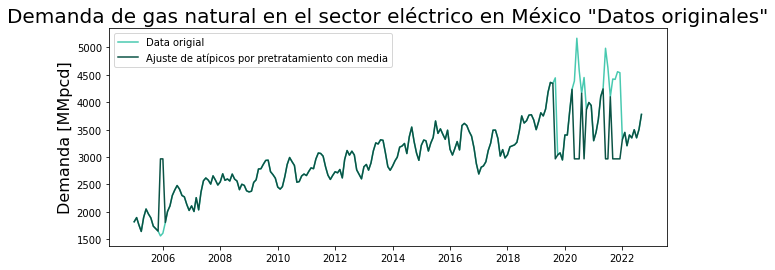

In [36]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.plot(demanda_electrico_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de media artimetica de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

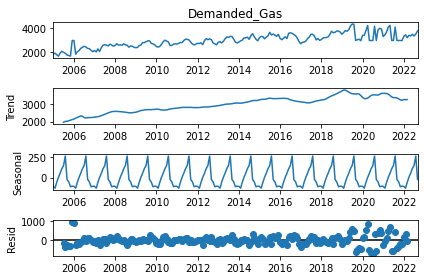

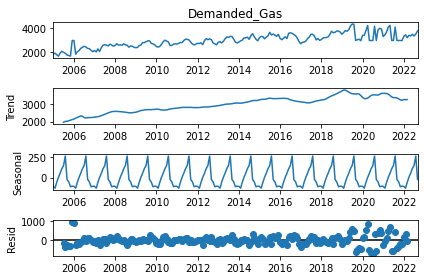

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_pretratamiento_media_seasonal_decomposition = seasonal_decompose(demanda_electrico_pretratamiento_media)
demanda_electrico_pretratamiento_media_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test para el caso de pretratamiento con la media artimetica

In [38]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_train_data_pretratamiento_media = demanda_electrico_pretratamiento_media[:-num_test_points]
demanda_electrico_test_data_pretratamiento_media = demanda_electrico_pretratamiento_media[-num_test_points:]

demanda_electrico_train_data_pretratamiento_media

Date
2005-01-01    1819.5800
2005-02-01    1895.3300
2005-03-01    1765.8600
2005-04-01    1642.7000
2005-05-01    1895.5400
                ...    
2021-05-01    4243.9300
2021-06-01    2967.1562
2021-07-01    2967.1562
2021-08-01    4098.8100
2021-09-01    2967.1562
Name: Demanded_Gas, Length: 201, dtype: float64

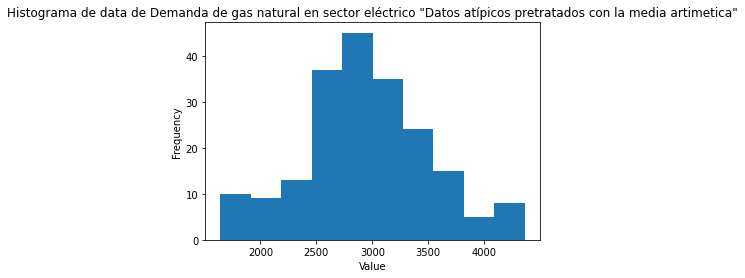

In [39]:
# Generate the histogram
plt.hist(demanda_electrico_train_data_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

In [41]:
demanda_electrico_train_data_pretratamiento_media.mean()

2946.4545373134333

In [42]:
demanda_electrico_train_data_pretratamiento_media.std()

559.2429783401235

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [40]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_data_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.1751261277135953
p-value: 0.9161610931770464


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

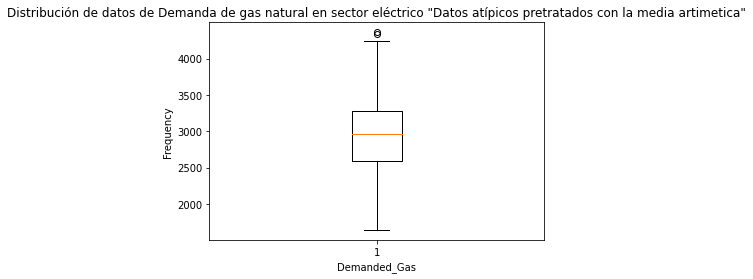

In [41]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_data_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [42]:
n_input = 24

data = demanda_electrico_train_data_pretratamiento_media
targets = data 

demanda_electrico_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [43]:
demanda_electrico_train_generator_pretratamiento_media[0]

(array([[1819.58  , 1895.33  , 1765.86  , 1642.7   , 1895.54  , 2051.72  ,
         1962.05  , 1889.66  , 1739.1   , 1695.92  , 1648.95  , 2967.1562,
         2967.1562, 1806.33  , 2006.88  , 2108.31  , 2298.9   , 2398.88  ,
         2480.62  , 2413.08  , 2298.49  , 2273.91  , 2134.41  , 2025.98  ]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [44]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_data_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU.  

In [46]:
n_input = 24
n_features = 1

# define model
model_FF_electrico_pretrataminto_media = Sequential()
model_FF_electrico_pretrataminto_media.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_pretrataminto_media.add(Dense(32, activation='relu'))
model_FF_electrico_pretrataminto_media.add(Dense(1))
model_FF_electrico_pretrataminto_media.compile(optimizer='Adam', loss='mse')

In [47]:
model_FF_electrico_pretrataminto_media.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24, 64)            128       
                                                                 
 dense_7 (Dense)             (None, 24, 32)            2080      
                                                                 
 dense_8 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [48]:
model_FF_electrico_pretrataminto_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=25)

Epoch 1/25


177/177 [==============================] - 1s 2ms/step - loss: 1002881.5625
Epoch 2/25
177/177 [==============================] - 1s 3ms/step - loss: 179732.1406
Epoch 3/25
177/177 [==============================] - 0s 2ms/step - loss: 181452.5625
Epoch 4/25
177/177 [==============================] - 0s 2ms/step - loss: 171980.5469
Epoch 5/25
177/177 [==============================] - 0s 2ms/step - loss: 176448.5625
Epoch 6/25
177/177 [==============================] - 0s 2ms/step - loss: 176468.4219
Epoch 7/25
177/177 [==============================] - 0s 2ms/step - loss: 176327.2500
Epoch 8/25
177/177 [==============================] - 1s 3ms/step - loss: 191261.1094
Epoch 9/25
177/177 [==============================] - 0s 2ms/step - loss: 175462.3438
Epoch 10/25
177/177 [==============================] - 0s 2ms/step - loss: 180069.5781
Epoch 11/25
177/177 [==============================] - 0s 2ms/step - loss: 182288.4219
Epoch 12/25
177/177 [==============================] - 0s 2ms/

Se grafica la perdida por epoch 

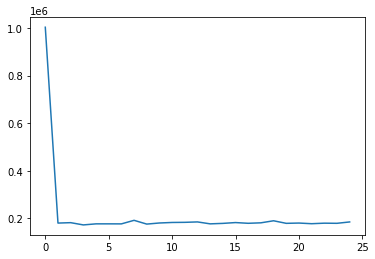

In [49]:
loss_per_epoch = model_FF_electrico_pretrataminto_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [50]:
demanda_electrico_train_batch_pretratamiento_media = demanda_electrico_train_data_pretratamiento_media.values[-n_input:]


demanda_electrico_train_batch_pretratamiento_media

array([3037.44  , 3076.62  , 2947.09  , 3402.47  , 3402.47  , 3819.3   ,
       4235.25  , 2967.1562, 2967.1562, 2967.1562, 4163.77  , 2967.1562,
       3869.77  , 3996.14  , 3941.12  , 3298.43  , 3454.21  , 3681.3   ,
       4104.82  , 4243.93  , 2967.1562, 2967.1562, 4098.81  , 2967.1562])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [51]:
demanda_electrico_train_batch_pretratamiento_media_reshaped = demanda_electrico_train_batch_pretratamiento_media.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_reshaped

array([[[3037.44  ],
        [3076.62  ],
        [2947.09  ],
        [3402.47  ],
        [3402.47  ],
        [3819.3   ],
        [4235.25  ],
        [2967.1562],
        [2967.1562],
        [2967.1562],
        [4163.77  ],
        [2967.1562],
        [3869.77  ],
        [3996.14  ],
        [3941.12  ],
        [3298.43  ],
        [3454.21  ],
        [3681.3   ],
        [4104.82  ],
        [4243.93  ],
        [2967.1562],
        [2967.1562],
        [4098.81  ],
        [2967.1562]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [52]:
model_FF_electrico_pretrataminto_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)

1/1 [==============================] - 0s 230ms/step


array([[[3215.5444],
        [3256.9717],
        [3120.0122],
        [3601.5122],
        [3601.5122],
        [4042.251 ],
        [4482.0596],
        [3141.2295],
        [3141.2295],
        [3141.2295],
        [4406.4795],
        [3141.2295],
        [4095.6157],
        [4229.235 ],
        [4171.058 ],
        [3491.5046],
        [3656.2197],
        [3896.3354],
        [4344.148 ],
        [4491.2373],
        [3141.2295],
        [3141.2295],
        [4337.793 ],
        [3141.2295]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [53]:
model_FF_electrico_pretrataminto_media.predict(demanda_electrico_train_batch_pretratamiento_media_reshaped)[0][-1][0]

1/1 [==============================] - 0s 29ms/step


3141.2295

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [54]:
n_input = 24
n_features = 1

In [55]:
test_predictions_model_FF_electrico_pretratamiento_media  = []

first_eval_batch = demanda_electrico_train_data_pretratamiento_media.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_test_data_pretratamiento_media)):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_pretrataminto_media.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain 

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 55ms/step


In [56]:
test_predictions_model_FF_electrico_pretratamiento_media

[3141.2295,
 3325.2874,
 3519.9023,
 3725.6802,
 3943.2615,
 4173.3228,
 4416.58,
 4673.7905,
 4945.7544,
 5233.318,
 5537.3755,
 5858.8735]

In [57]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_FF_electrico_pretratamiento_media_array = np.array(test_predictions_model_FF_electrico_pretratamiento_media)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_FF_electrico_pretratamiento_media_reshaped = test_predictions_model_FF_electrico_pretratamiento_media_array.reshape(-1, 1)

test_predictions_model_FF_electrico_pretratamiento_media_reshaped

array([[3141.2295],
       [3325.2874],
       [3519.9023],
       [3725.6802],
       [3943.2615],
       [4173.3228],
       [4416.58  ],
       [4673.7905],
       [4945.7544],
       [5233.318 ],
       [5537.3755],
       [5858.8735]], dtype=float32)

Separamos la Demanda de gas natural ORIGINAL en el sector eléctrico en data de train y test

In [58]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [62]:
demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

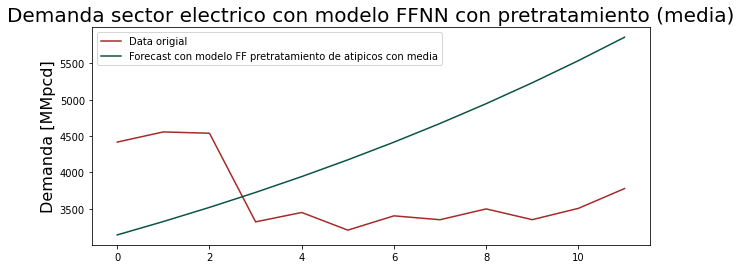

In [64]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_FF_electrico_pretratamiento_media_reshaped , color='#0B5345')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo FF pretratamiento de atipicos con media'))

plt.title('Demanda sector electrico con modelo FFNN con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [60]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_FF_electrico_pretratamiento_media = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_FF_electrico_pretratamiento_media_reshaped )
RMSE_test_predictions_model_FF_electrico_pretratamiento_media = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_FF_electrico_pretratamiento_media_reshaped ))

print('MAPE:', MAPE_test_predictions_model_FF_electrico_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_FF_electrico_pretratamiento_media)

MAPE: 0.3456735103866921
RMSE: 1366.1329323472232


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

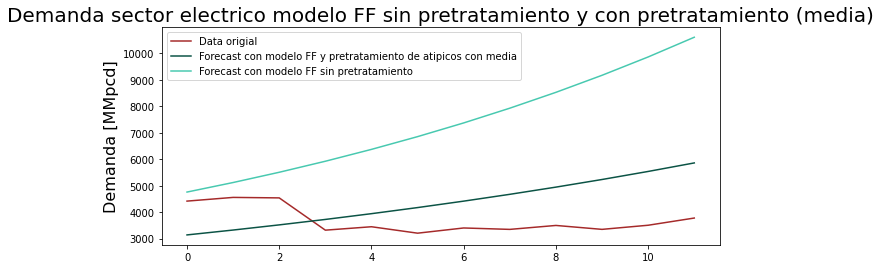

In [62]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_FF_electrico_pretratamiento_media_reshaped , color='#0B5345')
plt.plot(test_predictions_model_FF_sin_pretratamiento_rescaled, color='#48C9B0')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo FF y pretratamiento de atipicos con media', 'Forecast con modelo FF sin pretratamiento'))

plt.title('Demanda sector electrico con modelo FFNN sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [ ]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [65]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [66]:
csv_demanda_electrico_original_para_tratamiento2 =csv_demanda_electrico_original.copy()
csv_demanda_electrico_original_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


In [67]:
demanda_electrico_pretratamiento_mediana = remove_replace_outliers_mediana(csv_demanda_electrico_original_para_tratamiento2['Demanded_Gas'])
demanda_electrico_pretratamiento_mediana

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    1642.70
2005-05-01    1895.54
               ...   
2022-05-01    3350.03
2022-06-01    3498.70
2022-07-01    3350.97
2022-08-01    3506.42
2022-09-01    3778.37
Name: Demanded_Gas, Length: 213, dtype: float64

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test para el pretratamiento con la mediana 

In [68]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_train_data_pretratamiento_mediana = demanda_electrico_pretratamiento_mediana[:-num_test_points]
demanda_electrico_test_data_pretratamiento_mediana = demanda_electrico_pretratamiento_mediana[-num_test_points:]

demanda_electrico_train_data_pretratamiento_mediana

Date
2005-01-01    1819.580
2005-02-01    1895.330
2005-03-01    1765.860
2005-04-01    1642.700
2005-05-01    1895.540
                ...   
2021-05-01    4243.930
2021-06-01    2960.295
2021-07-01    2960.295
2021-08-01    4098.810
2021-09-01    2960.295
Name: Demanded_Gas, Length: 201, dtype: float64

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [69]:
n_input = 24

data = demanda_electrico_train_data_pretratamiento_mediana
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana[0]

(array([[1819.58 , 1895.33 , 1765.86 , 1642.7  , 1895.54 , 2051.72 ,
         1962.05 , 1889.66 , 1739.1  , 1695.92 , 1648.95 , 2960.295,
         2960.295, 1806.33 , 2006.88 , 2108.31 , 2298.9  , 2398.88 ,
         2480.62 , 2413.08 , 2298.49 , 2273.91 , 2134.41 , 2025.98 ]]),
 array([2108.85]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [70]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_data_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [71]:
n_input = 24
n_features = 1

# define model
model_FF_electrico_pretrataminto_mediana = Sequential()
model_FF_electrico_pretrataminto_mediana.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_electrico_pretrataminto_mediana.add(Dense(32, activation='relu'))
model_FF_electrico_pretrataminto_mediana.add(Dense(1))
model_FF_electrico_pretrataminto_mediana.compile(optimizer='Adam', loss='mse')
model_FF_electrico_pretrataminto_mediana.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24, 64)            128       
                                                                 
 dense_10 (Dense)            (None, 24, 32)            2080      
                                                                 
 dense_11 (Dense)            (None, 24, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
model_FF_electrico_pretrataminto_media.fit(demanda_electrico_train_generator_pretratamiento_media, epochs=25)

Epoch 1/25
177/177 [==============================] - 0s 3ms/step - loss: 183998.7500
Epoch 2/25
177/177 [==============================] - 1s 3ms/step - loss: 182060.9062
Epoch 3/25
177/177 [==============================] - 0s 2ms/step - loss: 179184.1875
Epoch 4/25
177/177 [==============================] - 0s 2ms/step - loss: 178643.8125
Epoch 5/25
177/177 [==============================] - 0s 2ms/step - loss: 181154.6719
Epoch 6/25
177/177 [==============================] - 0s 2ms/step - loss: 180922.1875
Epoch 7/25
177/177 [==============================] - 0s 2ms/step - loss: 183404.3281
Epoch 8/25
177/177 [==============================] - 1s 3ms/step - loss: 176748.0625
Epoch 9/25
177/177 [==============================] - 0s 2ms/step - loss: 174830.4375
Epoch 10/25
177/177 [==============================] - 0s 2ms/step - loss: 192721.8281
Epoch 11/25
177/177 [==============================] - 0s 2ms/step - loss: 175016.5312
Epoch 12/25
177/177 [==============================]

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [75]:
demanda_electrico_train_batch_pretratamiento_mediana = demanda_electrico_train_data_pretratamiento_mediana.values[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana

array([3037.44 , 3076.62 , 2947.09 , 3402.47 , 3402.47 , 3819.3  ,
       4235.25 , 2960.295, 2960.295, 2960.295, 4163.77 , 2960.295,
       3869.77 , 3996.14 , 3941.12 , 3298.43 , 3454.21 , 3681.3  ,
       4104.82 , 4243.93 , 2960.295, 2960.295, 4098.81 , 2960.295])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [76]:
demanda_electrico_train_batch_pretratamiento_mediana_reshaped = demanda_electrico_train_batch_pretratamiento_mediana.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_reshaped

array([[[3037.44 ],
        [3076.62 ],
        [2947.09 ],
        [3402.47 ],
        [3402.47 ],
        [3819.3  ],
        [4235.25 ],
        [2960.295],
        [2960.295],
        [2960.295],
        [4163.77 ],
        [2960.295],
        [3869.77 ],
        [3996.14 ],
        [3941.12 ],
        [3298.43 ],
        [3454.21 ],
        [3681.3  ],
        [4104.82 ],
        [4243.93 ],
        [2960.295],
        [2960.295],
        [4098.81 ],
        [2960.295]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [77]:
model_FF_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)


1/1 [==============================] - 0s 156ms/step


array([[[-660.5204 ],
        [-669.0403 ],
        [-640.8728 ],
        [-739.8994 ],
        [-739.8994 ],
        [-830.5432 ],
        [-920.99554],
        [-643.7443 ],
        [-643.7443 ],
        [-643.7443 ],
        [-905.4514 ],
        [-643.7443 ],
        [-841.5183 ],
        [-868.9986 ],
        [-857.0341 ],
        [-717.27515],
        [-751.151  ],
        [-800.5337 ],
        [-892.63226],
        [-922.8831 ],
        [-643.7443 ],
        [-643.7443 ],
        [-891.32526],
        [-643.7443 ]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [78]:
model_FF_electrico_pretrataminto_mediana.predict(demanda_electrico_train_batch_pretratamiento_mediana_reshaped)[0][-1][0]

1/1 [==============================] - 0s 36ms/step


-643.7443

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [ ]:
n_input = 24
n_features = 1

In [ ]:
test_predictions_model_FF_electrico_pretratamiento_mediana  = []

first_eval_batch = demanda_electrico_train_data_pretratamiento_mediana.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_test_data_pretratamiento_mediana)):
    
    # get the prediction value for the first batch
    current_pred = model_FF_electrico_pretrataminto_mediana.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_electrico_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain 

In [ ]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_FF_electrico_pretratamiento_mediana_array = np.array(test_predictions_model_FF_electrico_pretratamiento_mediana)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_FF_electrico_pretratamiento_mediana_reshaped = test_predictions_model_FF_electrico_pretratamiento_mediana_array.reshape(-1, 1)

test_predictions_model_FF_electrico_pretratamiento_mediana_reshaped

In [ ]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_FF_electrico_pretratamiento_mediana_reshaped , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)